#### 

In [1]:
Reset_initial = True

if Reset_initial:
    %run -i 'initial.py'

-471.0568564937796
2020-10-29 19:43:45,501 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s
2020-10-29 19:43:45,514 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2020-10-29 19:43:45,519 __main__ 0/1 INFO :: Perturbation norm: 17.365219865144315
2020-10-29 19:43:45,520 __main__ 0/1 INFO :: T iterate: 2.268591126035416
2020-10-29 19:43:45,520 __main__ 0/1 INFO :: P iterate: 11.937870498209637
2020-10-29 19:43:45,564 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2020-10-29 19:43:45,570 __main__ 0/1 INFO :: Perturbation norm: 4.548874464065178
2020-10-29 19:43:45,571 __main__ 0/1 INFO :: T iterate: 2.4780799537499414
2020-10-29 19:43:45,572 __main__ 0/1 INFO :: P iterate: 12.686044882904369
2020-10-29 19:43:45,590 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2020-10-29 19:43:45,594 __mai

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits

import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools

In [3]:
a_1 = 1 # Location of disk 
AU = 1.496e13
Mp = 1 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 300.0
disk density: 2.4e-09
hill radius: 2.0000e+11
bondi radius: 4.0000e+10


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
# r_outer = 1.496e13/r_0
r_outer = 1.2e12/r_0
r_outer = r_Hill / r_0 #3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-10 #1e-2
tolerance = 1e-10 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr'], ncc_cutoff = ncc_cutoff)


In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 
problem.parameters['M_0'] = M_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

Core_mass = Mp*5.972e27 # 5*5.972e27
problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass # 5* mass of earth (in g)
problem.parameters['mu'] = mu #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = kb # g*cm**2/(K*s**2)
problem.parameters['G'] = G # cm**3/(g*s**2)
problem.parameters['dMtot'] = dMtot # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = sig # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = s0 # cm
problem.parameters['rho_o'] = rho_o #g cm^-3 grain internal density
problem.parameters['sigma_b'] = sigma_b # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
problem.parameters['grad_rad_cst'] = grad_rad_cst

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = "(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)" # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)

In [7]:
# Opacity


problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898
 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)
# problem.substitutions['Qe'] = "x*exp(lgT)*T_0 + 0.5*(2 - x*exp(lgT)*T_0)*tanh((x*T_0*exp(lgT) - 2)/2*10 + 1)" 

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)"
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)"
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [8]:
# Gradient  

# problem.parameters['grad_rad_cst'] = -3/64*np.pi*problem.parameters['dMtot']/(problem.parameters['sigma_b']*rcore)
problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"
grad_rad = grad_rad_cst*kappa*np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad

# min
k1 = -10. # -30.
problem.parameters['k1'] = k1

grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 


In [9]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

# problem.substitutions['Lg'] = '1.30537485e-9/rho_g'
problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 10 #1 #15
problem.parameters['l'] = l
problem.substitutions['max'] = "(0.5*(1 + (9/4*s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)

problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [10]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [11]:
# New equations

dMdep = 5e-9*5.972e27/3.154e7 
problem.parameters['dMdep'] = dMdep

problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop)')

In [12]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('exp(r) * dr(lgP) = -gm*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

In [13]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3)") 

In [14]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-10-29 19:43:46,955 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+01/s


Text(0.5, 1.0, 'lgM')

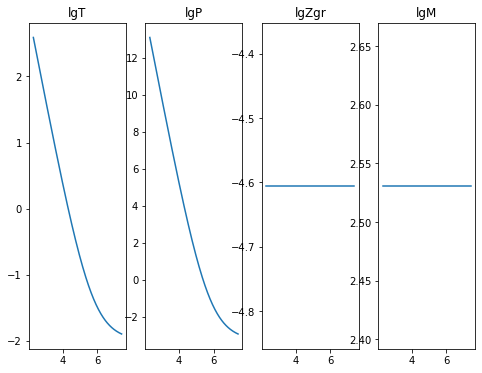

In [15]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
R = np.exp(lgr)*r_0
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

# Load from constant version
lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']


if not Reset_initial:
    lgM1['g'] = np.loadtxt('M.txt')
    lgZgr1['g'] = np.loadtxt('Zgr.txt')

else:
    lgZgr1['g'] = np.log(ones * 1e-2)
    #previously s was 1e-4
    lgM1['g'] = np.log(ones * 4/3*np.pi*problem.parameters['rho_o']*(1e-4)**3/ M_0) 


plt.figure(figsize=(8,6))
plt.subplot(1,4,1)
plt.plot(domain.grid(0),lgT1['g'])
plt.title("lgT")
plt.subplot(1,4,2)
plt.plot(domain.grid(0), lgP1['g'])
plt.title("lgP")
plt.subplot(1,4,3)
plt.plot(domain.grid(0),lgZgr1['g'])
plt.title("lgZgr")
plt.subplot(1,4,4)
plt.plot(domain.grid(0), lgM1['g'])
plt.title("lgM")

In [16]:
# Analysis 

# output = solver.evaluator.add_file_handler('output', iter =1 , max_writes = 100, mode='overwrite')
# output.add_task("exp(r)*r_0/v_set", layout ='g', name ='T_set')

# analysis = solver.evaluator.add_file_handler('analysis', wall_dt = 30)
# analysis.add_task("exp(r)*r_0/v_set", layout ='g', name ='T_set')

In [17]:
lgT_list = [np.copy(lgT['g'])]
lgP_list = [np.copy(lgP['g'])]
lgZgr_list = [np.copy(lgZgr['g'])]
lgM_list = [np.copy(lgM['g'])]

2020-10-29 19:43:49,408 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s
2020-10-29 19:43:49,631 __main__ 0/1 INFO :: Perturbation norm: 37.35630264473257
2020-10-29 19:43:49,632 __main__ 0/1 INFO :: lgT iterate: 1.411097175014935
2020-10-29 19:43:49,633 __main__ 0/1 INFO :: lgP iterate: 6.7550340119122305
2020-10-29 19:43:49,634 __main__ 0/1 INFO :: lgM iterate: -1.741306965056081
2020-10-29 19:43:49,634 __main__ 0/1 INFO :: lgZgr iterate: 0.8754082376318686


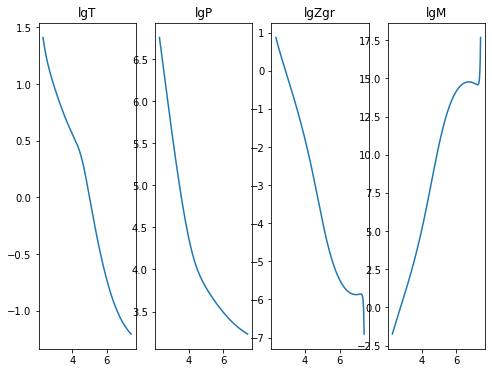

2020-10-29 19:43:51,997 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s
2020-10-29 19:43:52,187 __main__ 0/1 INFO :: Perturbation norm: 18.11020311435329
2020-10-29 19:43:52,188 __main__ 0/1 INFO :: lgT iterate: 0.9562224090072258
2020-10-29 19:43:52,189 __main__ 0/1 INFO :: lgP iterate: 11.113601514939056
2020-10-29 19:43:52,190 __main__ 0/1 INFO :: lgM iterate: 4.956062594055451
2020-10-29 19:43:52,190 __main__ 0/1 INFO :: lgZgr iterate: -1.5844884156275008


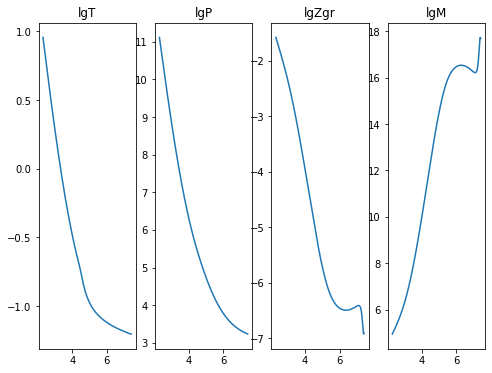

2020-10-29 19:43:54,540 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s
2020-10-29 19:43:54,737 __main__ 0/1 INFO :: Perturbation norm: 7.286130800356437
2020-10-29 19:43:54,738 __main__ 0/1 INFO :: lgT iterate: 1.0920043878509271
2020-10-29 19:43:54,739 __main__ 0/1 INFO :: lgP iterate: 11.906140030590631
2020-10-29 19:43:54,740 __main__ 0/1 INFO :: lgM iterate: 6.743353027480362
2020-10-29 19:43:54,740 __main__ 0/1 INFO :: lgZgr iterate: -2.1124246158137447


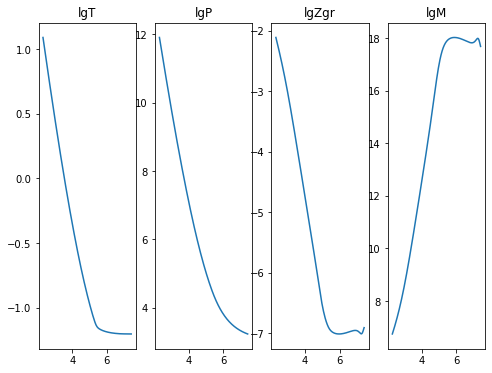

2020-10-29 19:43:57,485 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s
2020-10-29 19:43:57,696 __main__ 0/1 INFO :: Perturbation norm: 7.706270227451243
2020-10-29 19:43:57,697 __main__ 0/1 INFO :: lgT iterate: 1.073397601208868
2020-10-29 19:43:57,698 __main__ 0/1 INFO :: lgP iterate: 12.725735197695569
2020-10-29 19:43:57,698 __main__ 0/1 INFO :: lgM iterate: 7.246592577303122
2020-10-29 19:43:57,699 __main__ 0/1 INFO :: lgZgr iterate: -3.486963192324252


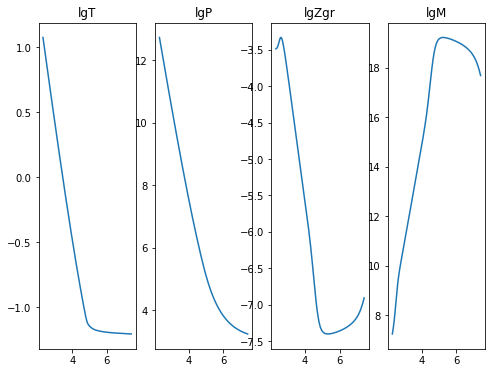

2020-10-29 19:44:01,152 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s
2020-10-29 19:44:01,458 __main__ 0/1 INFO :: Perturbation norm: 6.981087481899113
2020-10-29 19:44:01,459 __main__ 0/1 INFO :: lgT iterate: 1.0476475021888214
2020-10-29 19:44:01,460 __main__ 0/1 INFO :: lgP iterate: 13.3944553917145
2020-10-29 19:44:01,461 __main__ 0/1 INFO :: lgM iterate: 7.865400894412652
2020-10-29 19:44:01,461 __main__ 0/1 INFO :: lgZgr iterate: -4.671454955779162


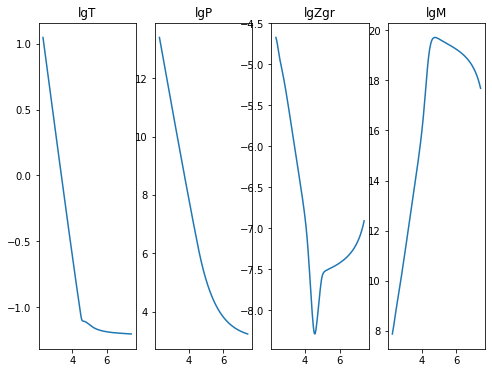

2020-10-29 19:44:04,611 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-10-29 19:44:04,869 __main__ 0/1 INFO :: Perturbation norm: 8.452097772287528
2020-10-29 19:44:04,870 __main__ 0/1 INFO :: lgT iterate: 1.0097578866247419
2020-10-29 19:44:04,873 __main__ 0/1 INFO :: lgP iterate: 14.227902051646856
2020-10-29 19:44:04,876 __main__ 0/1 INFO :: lgM iterate: 8.62154180943406
2020-10-29 19:44:04,878 __main__ 0/1 INFO :: lgZgr iterate: -6.065832623690467


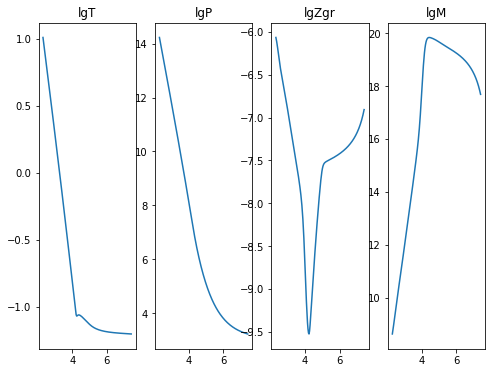

2020-10-29 19:44:08,742 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-10-29 19:44:08,956 __main__ 0/1 INFO :: Perturbation norm: 9.789872251550952
2020-10-29 19:44:08,957 __main__ 0/1 INFO :: lgT iterate: 0.9647922767277679
2020-10-29 19:44:08,958 __main__ 0/1 INFO :: lgP iterate: 15.140675312454109
2020-10-29 19:44:08,959 __main__ 0/1 INFO :: lgM iterate: 9.480080124529726
2020-10-29 19:44:08,959 __main__ 0/1 INFO :: lgZgr iterate: -7.618413178157032


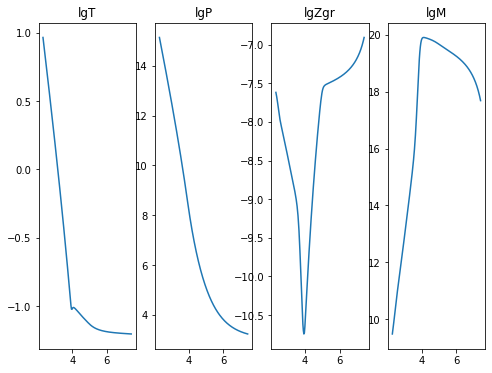

2020-10-29 19:44:12,726 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
2020-10-29 19:44:13,313 __main__ 0/1 INFO :: Perturbation norm: 10.833623453978067
2020-10-29 19:44:13,313 __main__ 0/1 INFO :: lgT iterate: 0.9063593490967092
2020-10-29 19:44:13,318 __main__ 0/1 INFO :: lgP iterate: 16.18080668382066
2020-10-29 19:44:13,321 __main__ 0/1 INFO :: lgM iterate: 10.403516698381914
2020-10-29 19:44:13,327 __main__ 0/1 INFO :: lgZgr iterate: -9.36181832374521


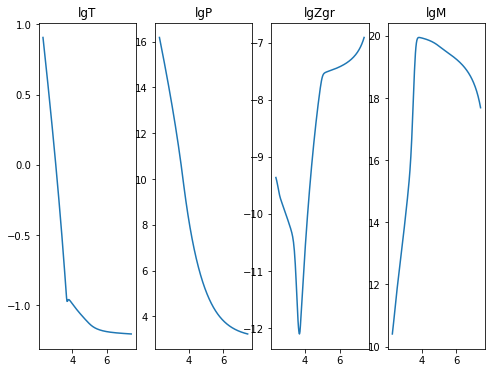

2020-10-29 19:44:17,582 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-10-29 19:44:17,806 __main__ 0/1 INFO :: Perturbation norm: 10.008987476639996
2020-10-29 19:44:17,807 __main__ 0/1 INFO :: lgT iterate: 0.8684735964686119
2020-10-29 19:44:17,807 __main__ 0/1 INFO :: lgP iterate: 16.846174065812
2020-10-29 19:44:17,808 __main__ 0/1 INFO :: lgM iterate: 11.373004178721574
2020-10-29 19:44:17,810 __main__ 0/1 INFO :: lgZgr iterate: -10.730339318873025


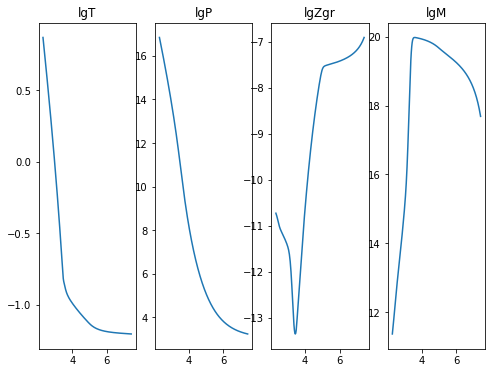

2020-10-29 19:44:20,573 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s
2020-10-29 19:44:20,765 __main__ 0/1 INFO :: Perturbation norm: 7.879782089835124
2020-10-29 19:44:20,766 __main__ 0/1 INFO :: lgT iterate: 0.8771376418262755
2020-10-29 19:44:20,767 __main__ 0/1 INFO :: lgP iterate: 16.760780094287018
2020-10-29 19:44:20,767 __main__ 0/1 INFO :: lgM iterate: 12.386532365077333
2020-10-29 19:44:20,768 __main__ 0/1 INFO :: lgZgr iterate: -11.30763473822307


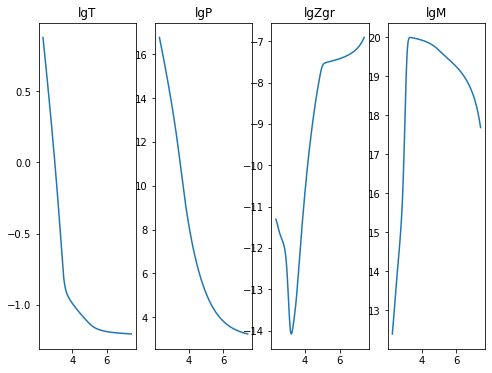

2020-10-29 19:44:23,478 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:23,699 __main__ 0/1 INFO :: Perturbation norm: 7.871206111713399
2020-10-29 19:44:23,700 __main__ 0/1 INFO :: lgT iterate: 0.8771687885078394
2020-10-29 19:44:23,701 __main__ 0/1 INFO :: lgP iterate: 16.76235655501104
2020-10-29 19:44:23,702 __main__ 0/1 INFO :: lgM iterate: 13.427023752827626
2020-10-29 19:44:23,702 __main__ 0/1 INFO :: lgZgr iterate: -12.002825404362344


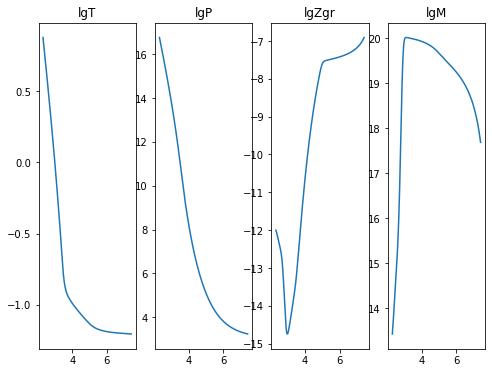

2020-10-29 19:44:26,376 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:26,599 __main__ 0/1 INFO :: Perturbation norm: 8.124618008583603
2020-10-29 19:44:26,600 __main__ 0/1 INFO :: lgT iterate: 0.8771687834209554
2020-10-29 19:44:26,601 __main__ 0/1 INFO :: lgP iterate: 16.762356685927458
2020-10-29 19:44:26,602 __main__ 0/1 INFO :: lgM iterate: 14.578802819435767
2020-10-29 19:44:26,602 __main__ 0/1 INFO :: lgZgr iterate: -12.770678253891905


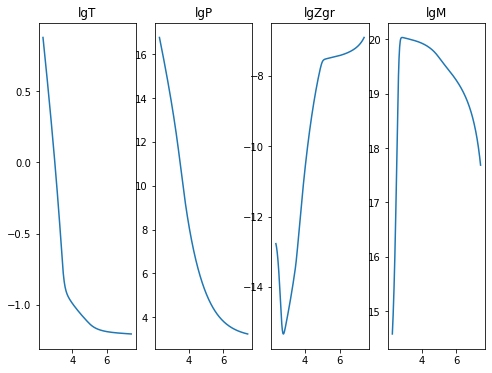

2020-10-29 19:44:29,258 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:29,455 __main__ 0/1 INFO :: Perturbation norm: 8.4583516198145
2020-10-29 19:44:29,456 __main__ 0/1 INFO :: lgT iterate: 0.8771687837885487
2020-10-29 19:44:29,457 __main__ 0/1 INFO :: lgP iterate: 16.76235668753675
2020-10-29 19:44:29,458 __main__ 0/1 INFO :: lgM iterate: 17.05458592792376
2020-10-29 19:44:29,459 __main__ 0/1 INFO :: lgZgr iterate: -14.421200327278893


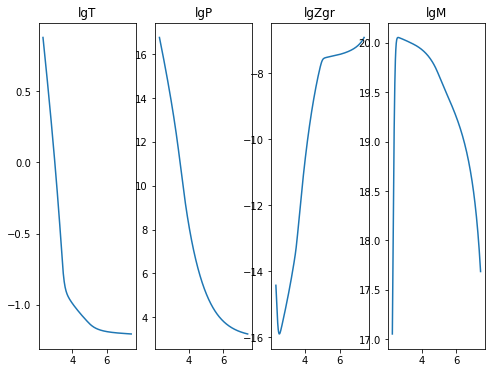

2020-10-29 19:44:32,943 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2020-10-29 19:44:33,152 __main__ 0/1 INFO :: Perturbation norm: 5.323576107993982
2020-10-29 19:44:33,153 __main__ 0/1 INFO :: lgT iterate: 0.877168782491552
2020-10-29 19:44:33,157 __main__ 0/1 INFO :: lgP iterate: 16.762356671034123
2020-10-29 19:44:33,157 __main__ 0/1 INFO :: lgM iterate: 20.003601661129043
2020-10-29 19:44:33,160 __main__ 0/1 INFO :: lgZgr iterate: -16.387210801507436


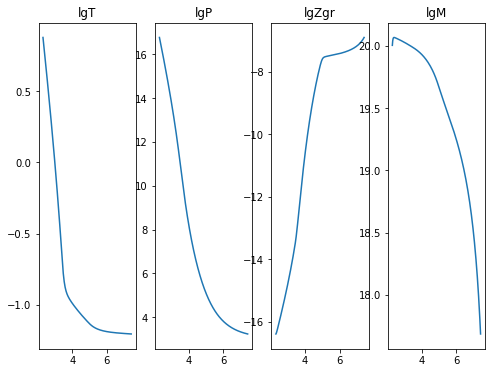

2020-10-29 19:44:35,854 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
2020-10-29 19:44:36,065 __main__ 0/1 INFO :: Perturbation norm: 0.1179707152899619
2020-10-29 19:44:36,066 __main__ 0/1 INFO :: lgT iterate: 0.8771687808117291
2020-10-29 19:44:36,066 __main__ 0/1 INFO :: lgP iterate: 16.76235665778134
2020-10-29 19:44:36,067 __main__ 0/1 INFO :: lgM iterate: 20.074144312273795
2020-10-29 19:44:36,068 __main__ 0/1 INFO :: lgZgr iterate: -16.43423922488982


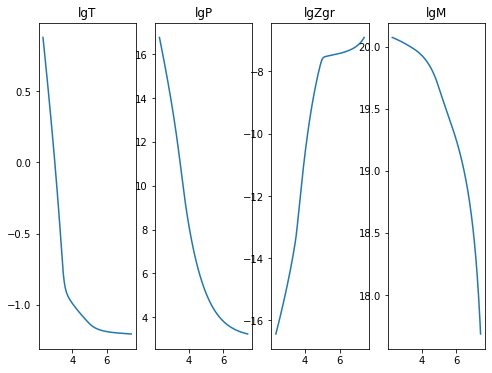

2020-10-29 19:44:38,771 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:38,965 __main__ 0/1 INFO :: Perturbation norm: 3.536259578247599e-06
2020-10-29 19:44:38,966 __main__ 0/1 INFO :: lgT iterate: 0.8771687807883357
2020-10-29 19:44:38,969 __main__ 0/1 INFO :: lgP iterate: 16.76235665775671
2020-10-29 19:44:38,970 __main__ 0/1 INFO :: lgM iterate: 20.07414642380959
2020-10-29 19:44:38,973 __main__ 0/1 INFO :: lgZgr iterate: -16.43424063258847


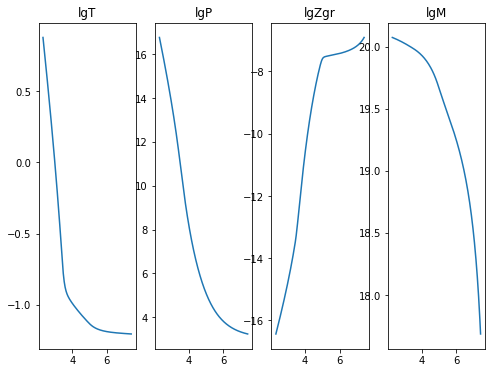

2020-10-29 19:44:41,634 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:42,100 __main__ 0/1 INFO :: Perturbation norm: 1.7016093903513195e-10
2020-10-29 19:44:42,101 __main__ 0/1 INFO :: lgT iterate: 0.8771687807882022
2020-10-29 19:44:42,105 __main__ 0/1 INFO :: lgP iterate: 16.76235665775666
2020-10-29 19:44:42,106 __main__ 0/1 INFO :: lgM iterate: 20.074146423813165
2020-10-29 19:44:42,109 __main__ 0/1 INFO :: lgZgr iterate: -16.434240632590953


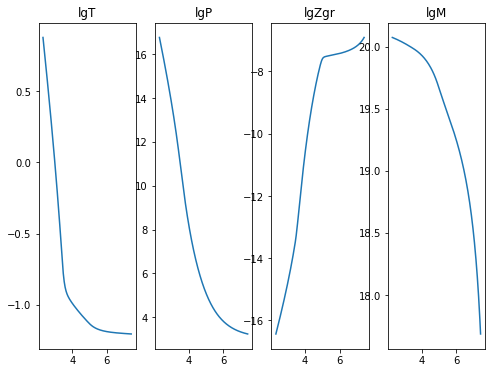

2020-10-29 19:44:44,751 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-10-29 19:44:44,949 __main__ 0/1 INFO :: Perturbation norm: 2.761589943385209e-11
2020-10-29 19:44:44,949 __main__ 0/1 INFO :: lgT iterate: 0.8771687807881745
2020-10-29 19:44:44,953 __main__ 0/1 INFO :: lgP iterate: 16.762356657756392
2020-10-29 19:44:44,977 __main__ 0/1 INFO :: lgM iterate: 20.074146423813414
2020-10-29 19:44:44,978 __main__ 0/1 INFO :: lgZgr iterate: -16.43424063259091


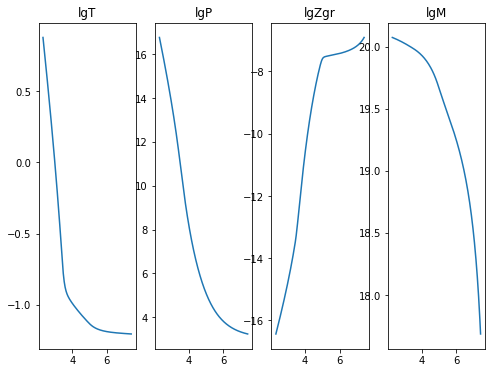

In [18]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,4,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,4,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,4,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,4,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.show()
    
end_time = time.time()

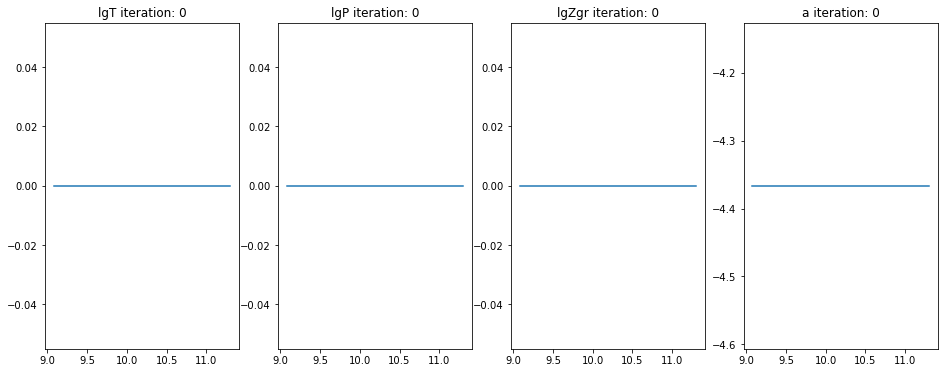

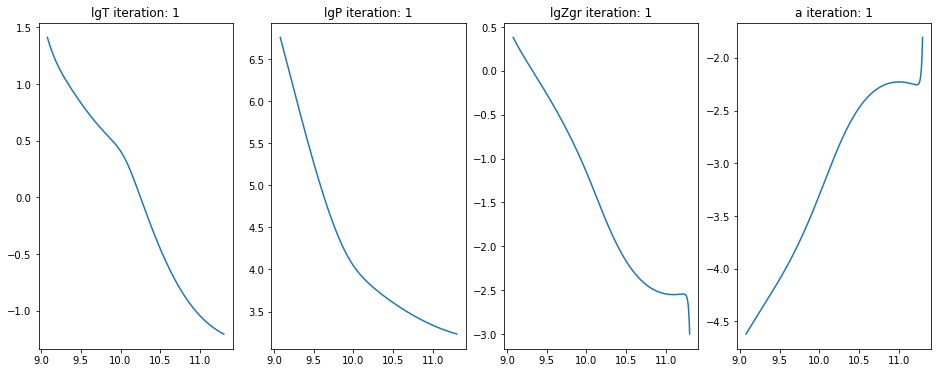

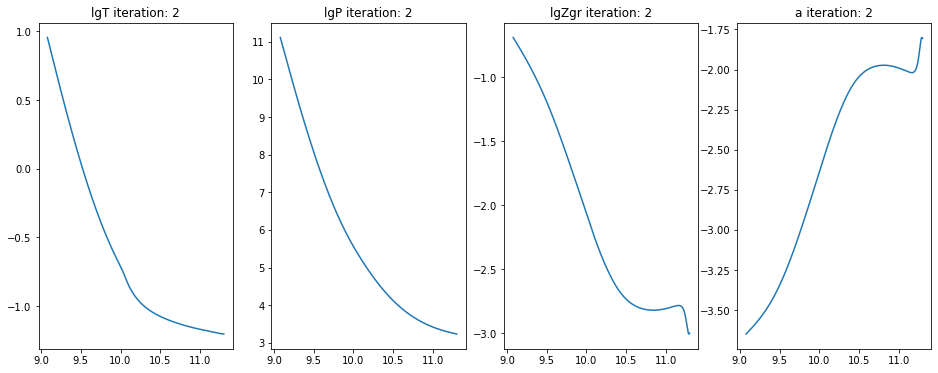

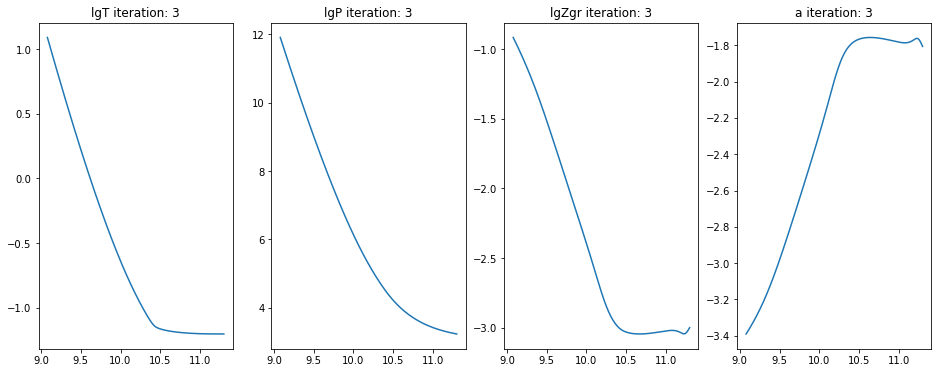

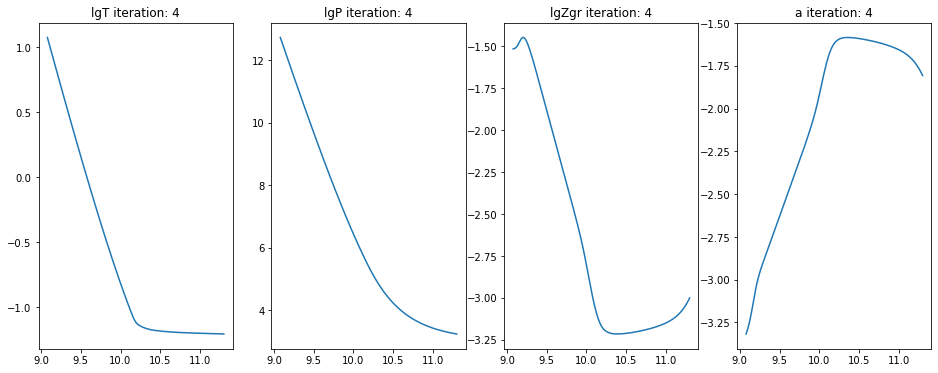

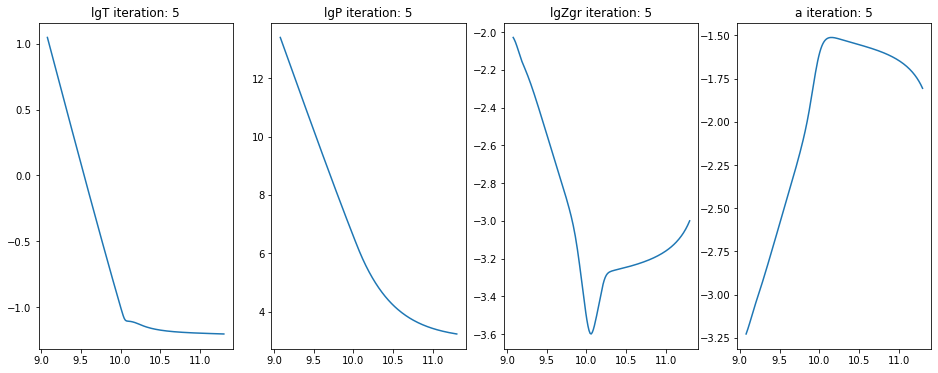

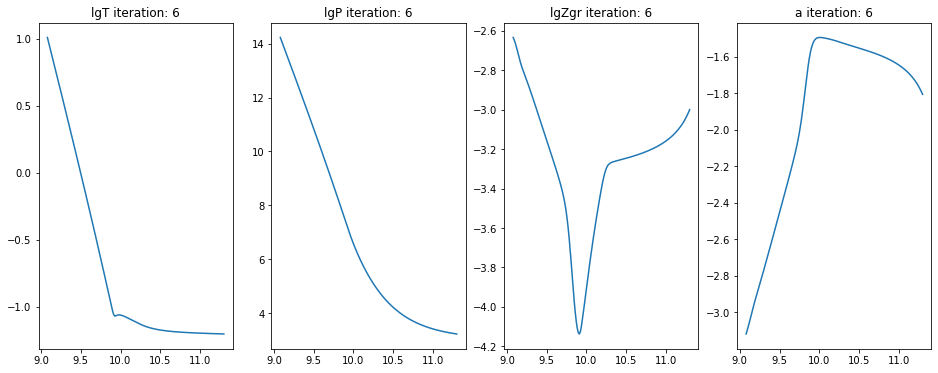

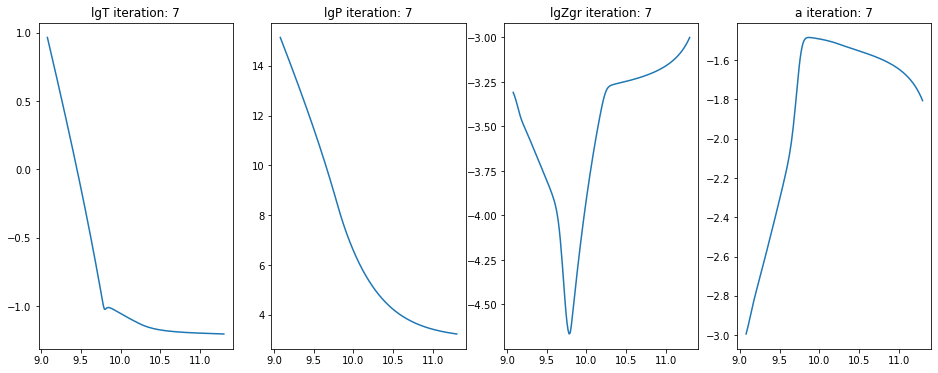

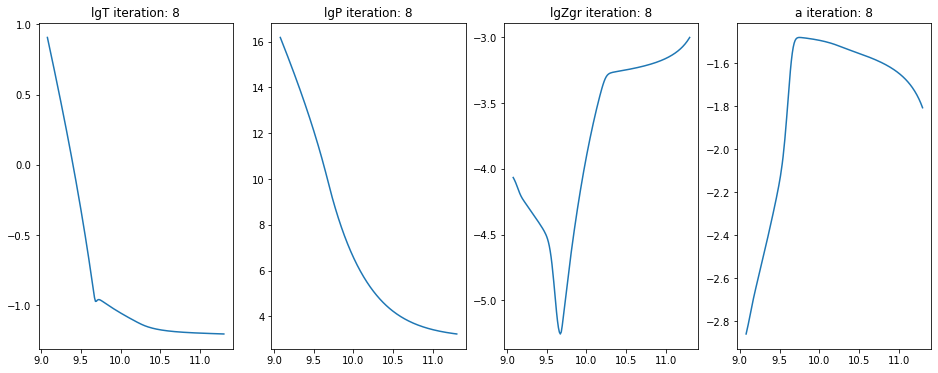

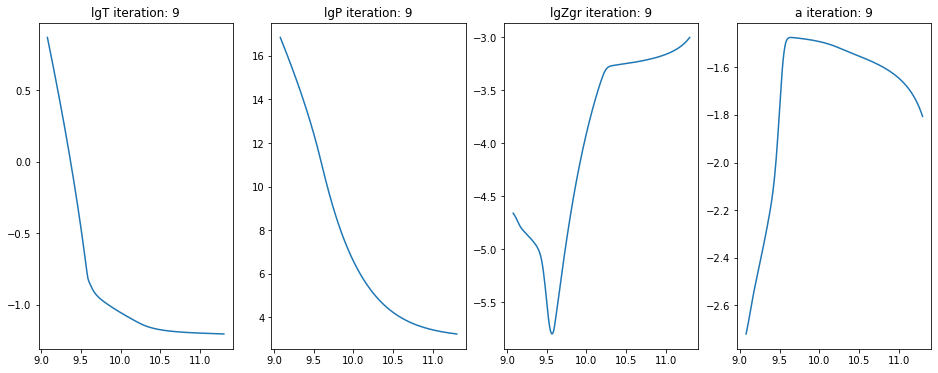

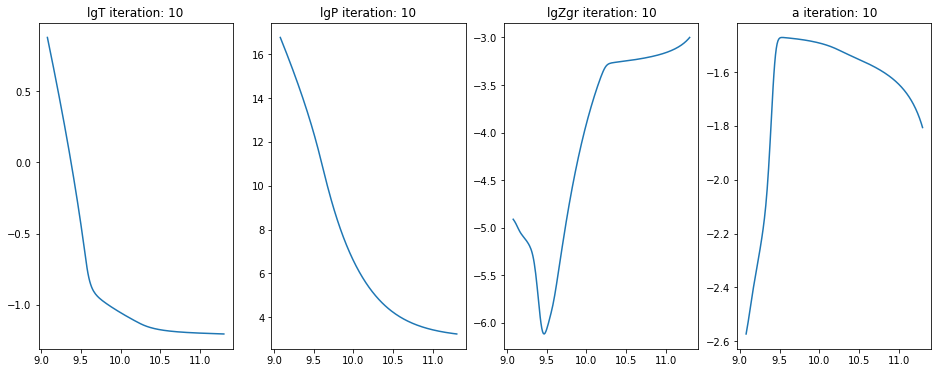

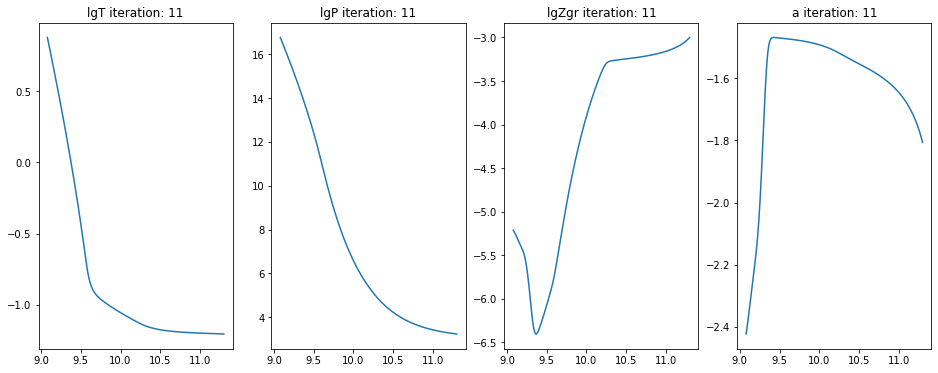

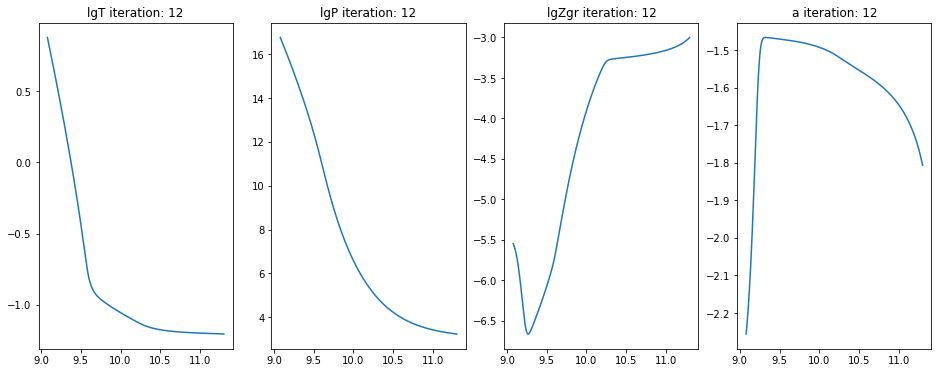

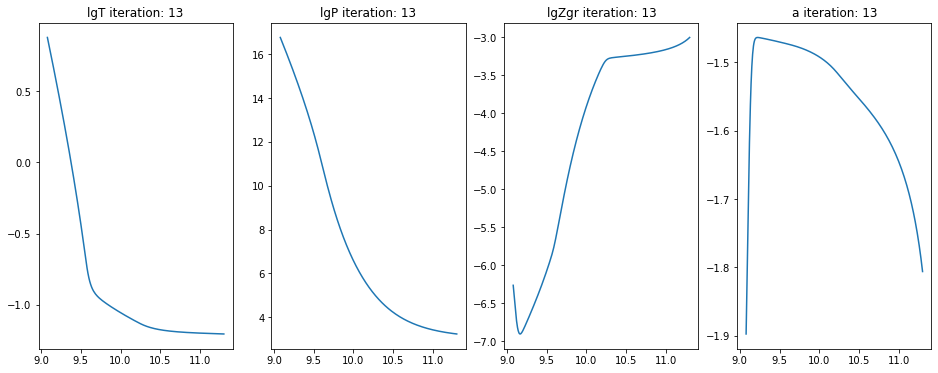

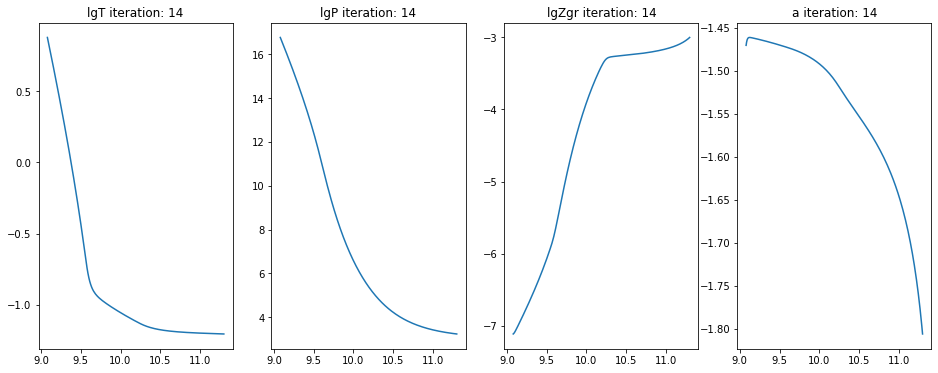

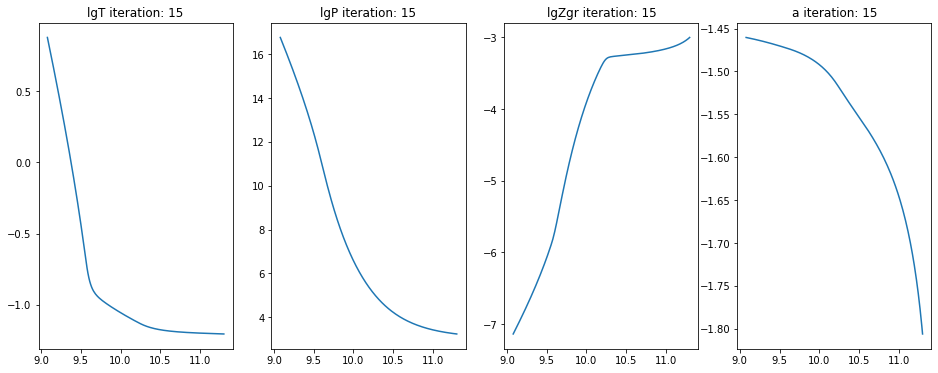

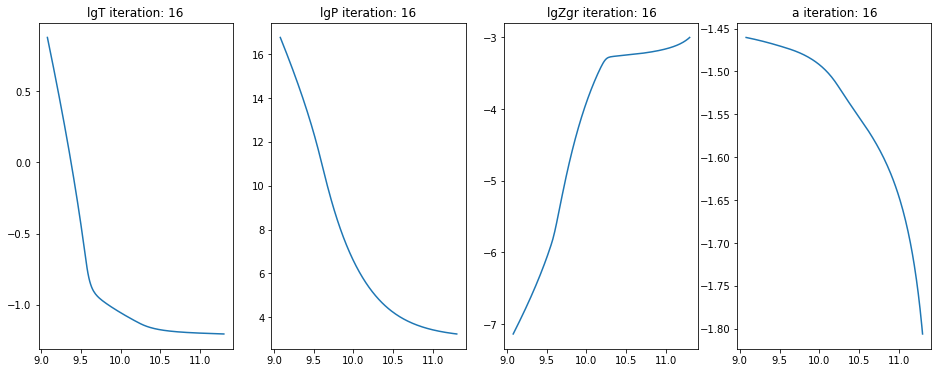

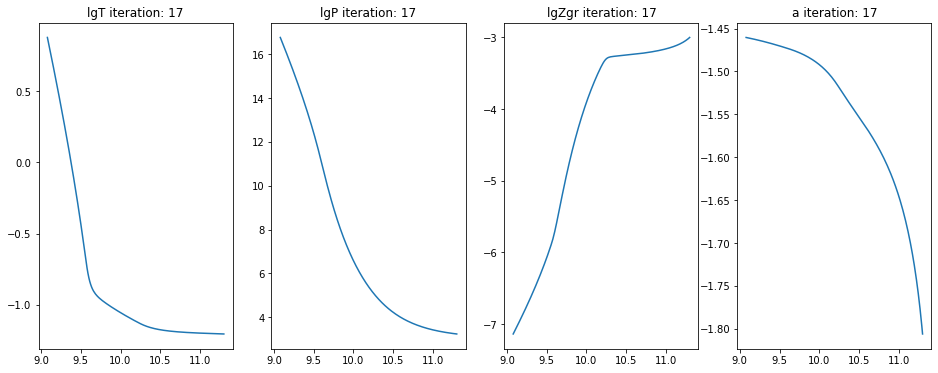

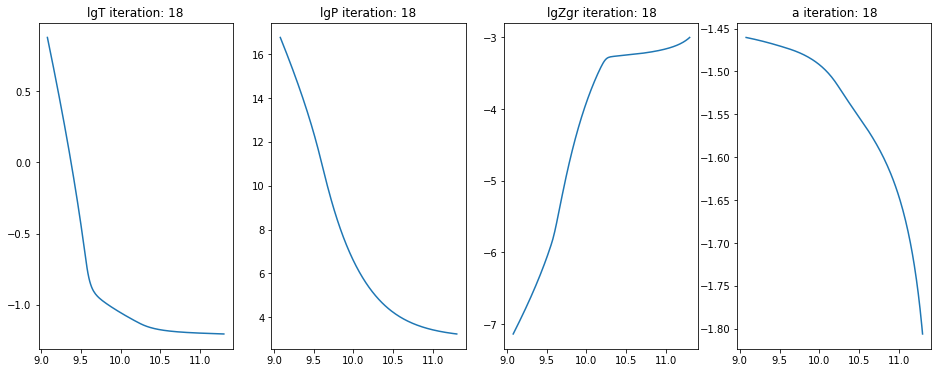

In [19]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,4,1)
        plt.plot(R,lgT_list[i])

        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,4,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,4,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("lgZgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,4,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))  

In [20]:
np.savetxt("Pressure.txt", lgP_list[-1])
np.savetxt("Temperature.txt", lgT_list[-1])
np.savetxt("Zgr.txt", lgZgr_list[-1])
np.savetxt("M.txt", lgM_list[-1])

lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]

Text(0.5, 1.0, 'Grad')

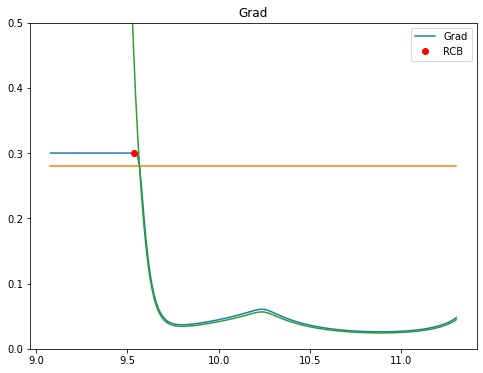

In [21]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, -Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

Trcb_set = 0.11778451793394948 yr
Tbondi_set = 37.992822114730856 yr
Tout_set = 2430.270274214996 yr


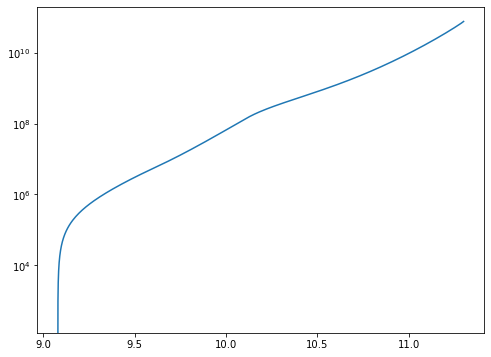

In [22]:
Bondi = r_Bondi # cm
# Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

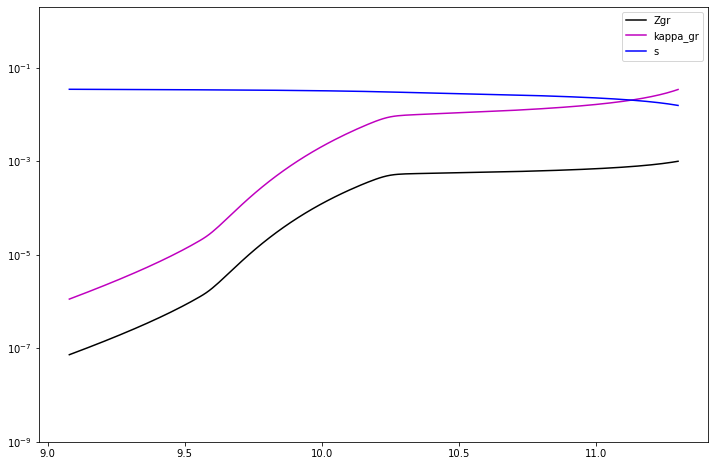

In [23]:
# Ormel profilel 

size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()

plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.yscale('log')
plt.ylim((1e-9, 0.2e1))
plt.legend()

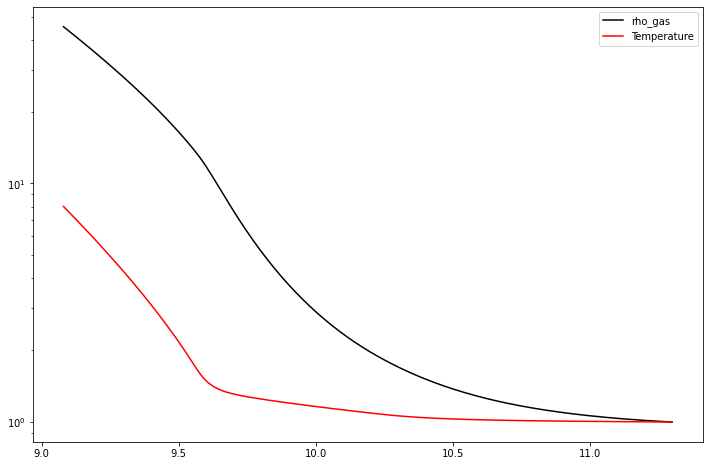

In [24]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgT = lgT_list[-1]

plt.figure(figsize=(12,8)) 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgT)*T_0/Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()
lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0

pi = np.pi 
rho_o = 3 
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])

rhodisk = 1e-11 #g/cm**3
Tdisk = 150 # kelvin

s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)



Envelope mass (g): 9.600418e+25


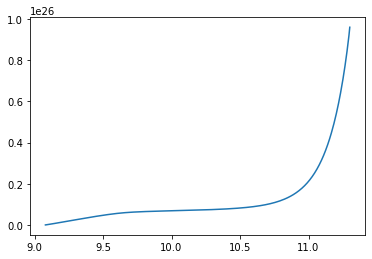

In [25]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

(-0.3, 0.4)

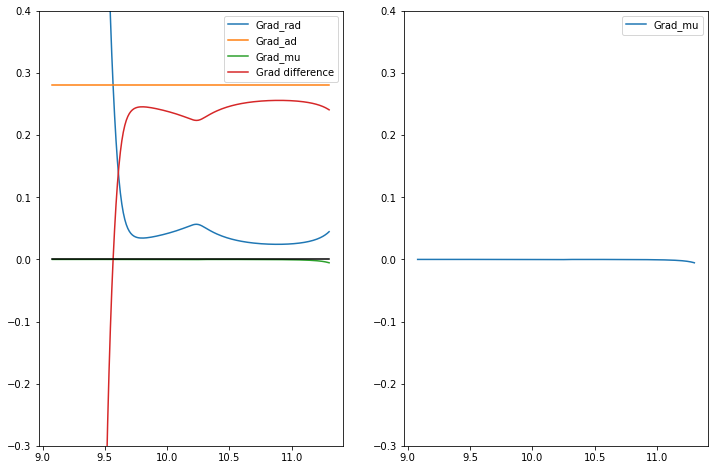

In [26]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, -Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-0.3, 0.4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-0.3, 0.4))

In [27]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')
# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g']
grad_mu *= np.exp(lgZgr['g'])

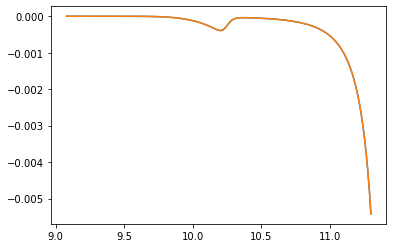

In [28]:
plt.plot(R, grad_mu)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')